In [1]:
from torchvision.datasets import CelebA
from torchvision.transforms.v2 import CenterCrop, Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, InterpolationMode, ToImage, ToDtype
import torch

train_transform = Compose([
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    RandomHorizontalFlip(),
    RandomRotation(15, InterpolationMode.BILINEAR),
    CenterCrop(178),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

normal_transform = Compose([
    CenterCrop(178),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

train = CelebA("data", "train", download=True, transform=train_transform)
valid = CelebA("data", "valid", download=True, transform=normal_transform)
test = CelebA("data", "test", download=True, transform=normal_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Number of pictures: 162770
Number of attributes: 40
Attribute names: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Resolution: torch.Size([3, 178, 178])


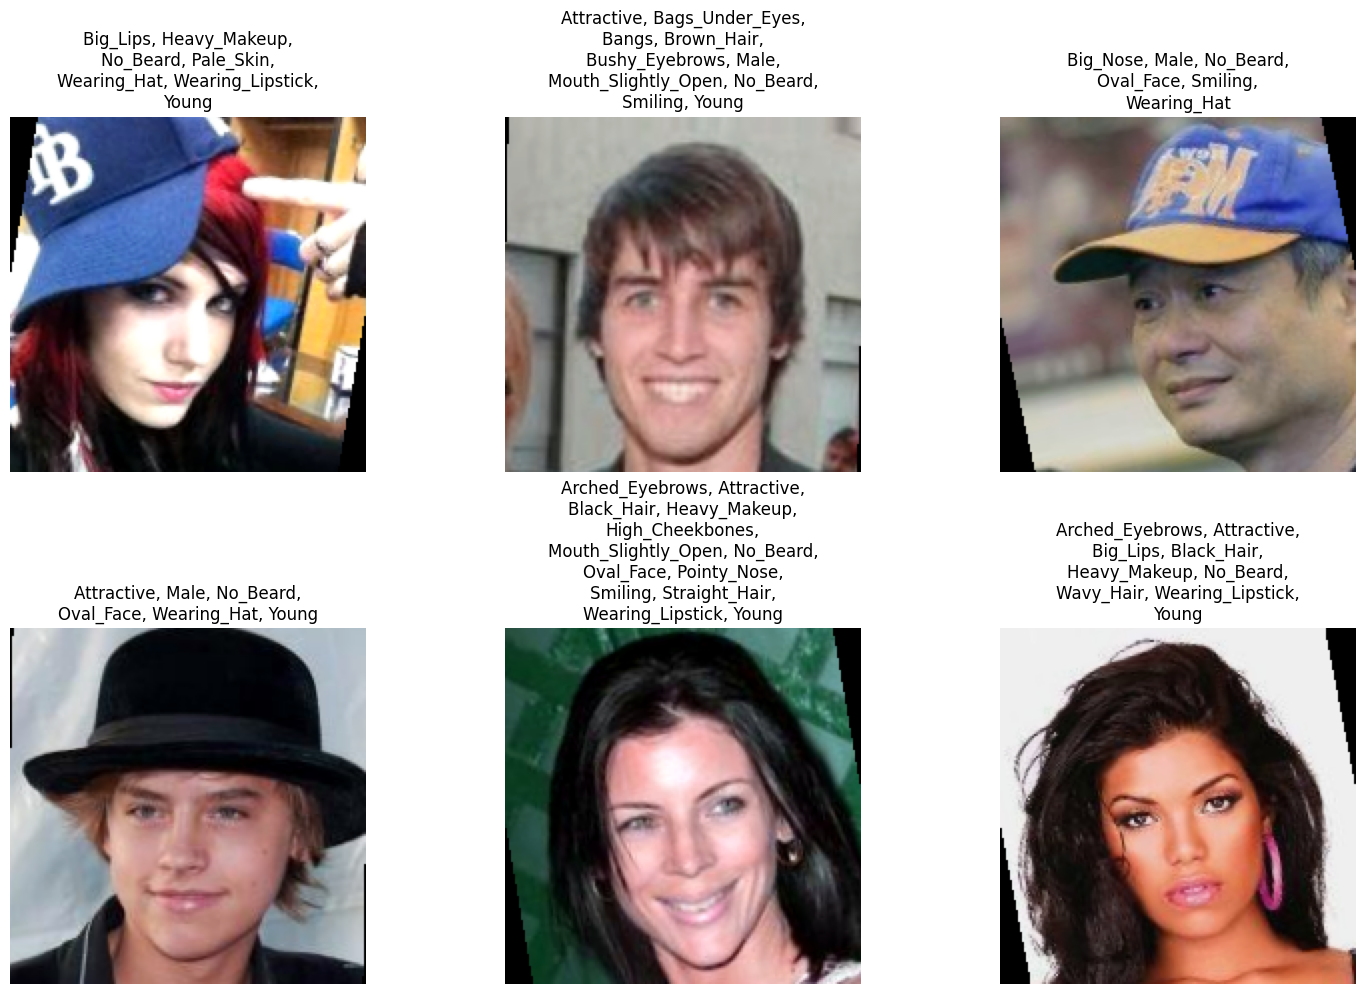

In [2]:
import matplotlib.pyplot as plt
import random
import textwrap

print(f"Number of pictures: {len(train)}")

print(f"Number of attributes: {len(train.attr_names[:-1])}")

print(f"Attribute names: {train.attr_names[:-1]}")

print(f"Resolution: {train[0][0].shape}")

# Define the number of rows and columns for the grid of images
ROWS = 2
COLS = 3

# Create subplots
fig, axs = plt.subplots(ROWS, COLS, figsize=(5*COLS, 5*ROWS))

# Randomly select images
selected_images = random.sample(range(len(train)), ROWS * COLS)

for i in range(ROWS * COLS):
    # Get attributes for the current image
    attrs = [attr for j, attr in enumerate(train.attr_names[:-1]) if train[selected_images[i]][1][j] == 1]
    
    # Calculate the row and column indices for the current image
    row = i // COLS
    col = i % COLS
    
    # Display the image
    axs[row, col].imshow(train[selected_images[i]][0].permute(1, 2, 0))

    # Remove the axes
    axs[row, col].axis('off')
    
    # Set the title to the attributes, with line breaks
    title = ", ".join(attrs)
    axs[row, col].set_title(textwrap.fill(title, 30))

# Show the plot
plt.tight_layout()
plt.show()

In [3]:
from efficientformer_v3 import EfficientFormerV3
from torch import cuda, backends

device = (
    "cuda"
    if cuda.is_available()
    else "mps"
    if backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

BATCH_SIZE = 64

model = EfficientFormerV3(batch_size=BATCH_SIZE).to(device)

/home/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [4]:
from torch import nn, optim, save

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)

from efficientformer_v3 import train_loop, test_loop
train_loop(train_loader, model, loss_fn, optimizer, device, epochs=2)
save(model.state_dict(), "./data/trained.pth")

Epoch: 1/2 loss: 0.697346  [   64/162770]
Epoch: 1/2 loss: 0.400313  [ 6464/162770]
Epoch: 1/2 loss: 0.342586  [12864/162770]
Epoch: 1/2 loss: 0.316195  [19264/162770]
Epoch: 1/2 loss: 0.322928  [25664/162770]
Epoch: 1/2 loss: 0.318768  [32064/162770]
Epoch: 1/2 loss: 0.281178  [38464/162770]
Epoch: 1/2 loss: 0.293642  [44864/162770]
Epoch: 1/2 loss: 0.279544  [51264/162770]
Epoch: 1/2 loss: 0.258773  [57664/162770]
Epoch: 1/2 loss: 0.265463  [64064/162770]
Epoch: 1/2 loss: 0.277776  [70464/162770]
Epoch: 1/2 loss: 0.247794  [76864/162770]
Epoch: 1/2 loss: 0.260756  [83264/162770]
Epoch: 1/2 loss: 0.252564  [89664/162770]
Epoch: 1/2 loss: 0.279874  [96064/162770]
Epoch: 1/2 loss: 0.256056  [102464/162770]
Epoch: 1/2 loss: 0.256413  [108864/162770]
Epoch: 1/2 loss: 0.241023  [115264/162770]
Epoch: 1/2 loss: 0.258450  [121664/162770]
Epoch: 1/2 loss: 0.248587  [128064/162770]
Epoch: 1/2 loss: 0.237836  [134464/162770]
Epoch: 1/2 loss: 0.232813  [140864/162770]
Epoch: 1/2 loss: 0.237655  

In [5]:
from torch import load

model = EfficientFormerV3(batch_size=BATCH_SIZE)
model.load_state_dict(load("./data/trained.pth"))
model.to(device)

test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

attribute_accuracy, baseline = test_loop(test_loader, model, loss_fn, device)
baseline = [item if item > 0.5 else 1 - item for item in baseline]

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.223173 



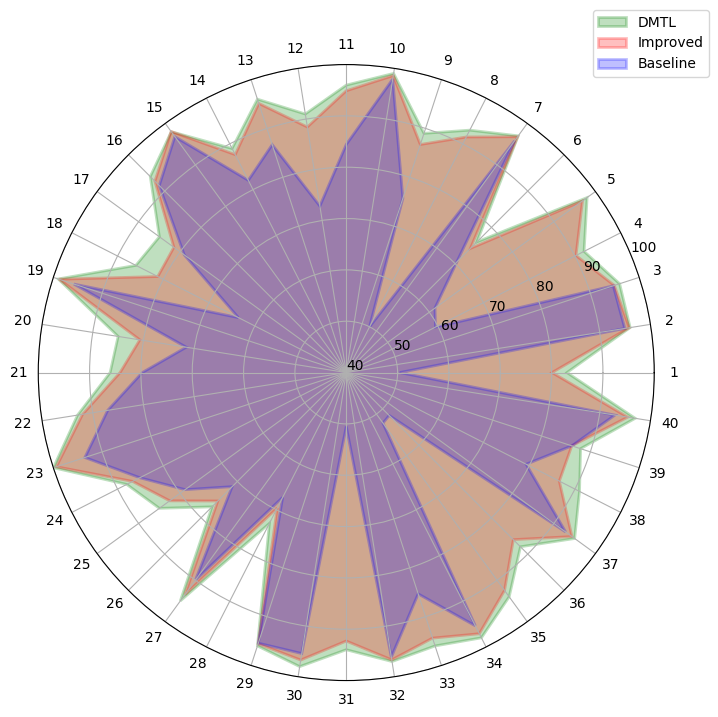

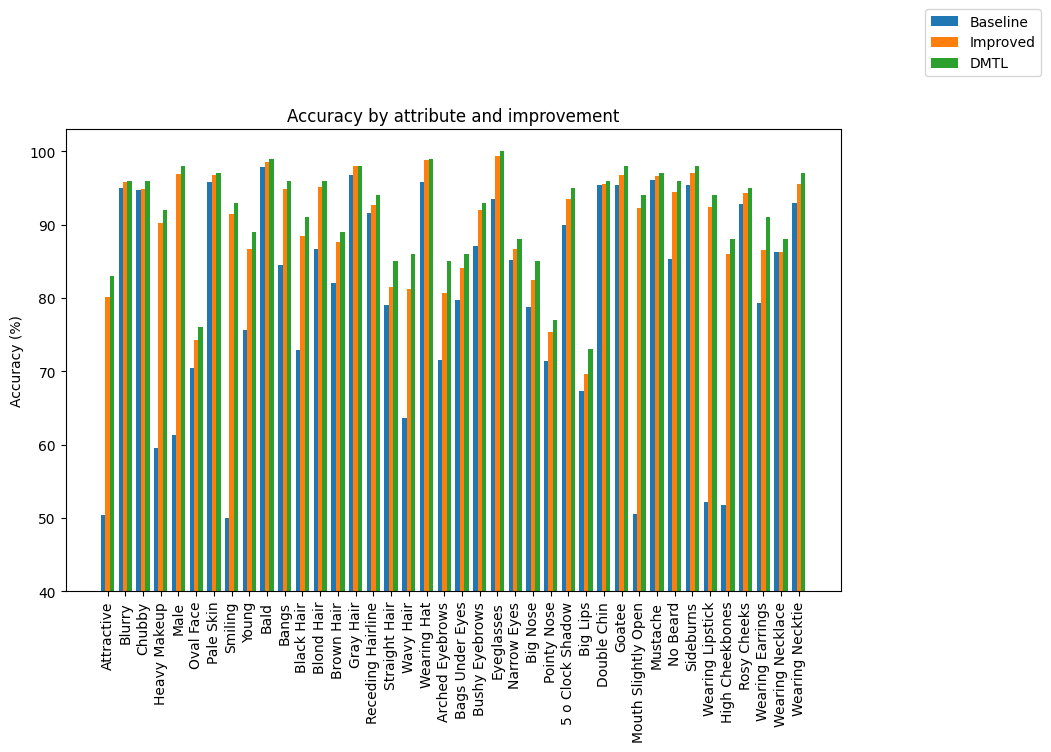

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming attribute_accuracy is a dictionary
labels = ['Attractive', 'Blurry', 'Chubby', 'Heavy_Makeup', 'Male', 'Oval_Face', 'Pale_Skin', 'Smiling', 'Young', 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Receding_Hairline', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Hat', 'Arched_Eyebrows', 'Bags_Under_Eyes', 'Bushy_Eyebrows', 'Eyeglasses', 'Narrow_Eyes', 'Big_Nose', 'Pointy_Nose', '5_o_Clock_Shadow', 'Big_Lips', 'Double_Chin', 'Goatee', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Sideburns', 'Wearing_Lipstick', 'High_Cheekbones', 'Rosy_Cheeks', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie']
labels = [label.replace("_", " ") for label in labels]

DMTL = [0.83, 0.96, 0.96, 0.92, 0.98, 0.76, 0.97, 0.93, 0.89, 0.99, 0.96, 0.91, 0.96, 0.89, 0.98, 0.94, 0.85, 0.86, 0.99, 0.85, 0.86, 0.93, 1.0, 0.88, 0.85, 0.77, 0.95, 0.73, 0.96, 0.98, 0.94, 0.97, 0.96, 0.98, 0.94, 0.88, 0.95, 0.91, 0.88, 0.97]

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, [i-0.4 for i in DMTL], color='green', alpha = 0.25, edgecolor='green', linewidth=2)
ax.fill(angles, [i-0.4 for i in attribute_accuracy], color='red', alpha = 0.25, edgecolor='red', linewidth=2)
ax.fill(angles, [i-0.4 for i in baseline], color='blue', alpha = 0.25, edgecolor='blue', linewidth=2)

ax.set_rmax(0.6)
ax.set_rticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks(angles)
#ax.set_xticklabels([f"{label}: {attribute_accuracy[i]*100:.2f}%" for i, label in enumerate(labels)])
ax.set_xticks(angles)
ax.set_xticklabels([f"{i+1}" for i in range(len(labels))])  # Change labels to index+1


# Add a legend to the polar plot
ax.legend(['DMTL', 'Improved', 'Baseline'], loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()


improved = attribute_accuracy

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, [i-0.4 for i in baseline], width, label='Baseline')
rects2 = ax.bar(x, [i-0.4 for i in improved], width, label='Improved')
rects3 = ax.bar(x + width, [i-0.4 for i in DMTL], width, label='DMTL')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by attribute and improvement')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
# Add a legend to the bar plot
ax.legend(['Baseline', 'Improved', 'DMTL'], loc='lower left', bbox_to_anchor=(1.1, 1.1))


plt.show()

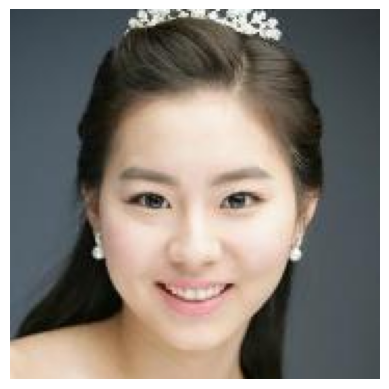

actual attributes: ['Attractive', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Smiling', 'Wearing_Earrings', 'Young']
expected attributes: ['Arched_Eyebrows', 'Attractive', 'Big_Lips', 'Big_Nose', 'Bushy_Eyebrows', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Oval_Face', 'Smiling', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young']


In [7]:
SAMPLE = 3456

example = test[SAMPLE][0]

plt.imshow(example.permute(1, 2, 0))
plt.axis("off")
plt.show()

output = model.forward(example.unsqueeze(0).to(device))
new_attributes = ['Attractive', 'Blurry', 'Chubby', 'Heavy_Makeup', 'Male', 'Oval_Face', 'Pale_Skin', 'Smiling', 'Young', 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Receding_Hairline', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Hat', 'Arched_Eyebrows', 'Bags_Under_Eyes', 'Bushy_Eyebrows', 'Eyeglasses', 'Narrow_Eyes', 'Big_Nose', 'Pointy_Nose', '5_o_Clock_Shadow', 'Big_Lips', 'Double_Chin', 'Goatee', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Sideburns', 'Wearing_Lipstick', 'High_Cheekbones', 'Rosy_Cheeks', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie']
actual = sorted((attr for i, attr in enumerate(new_attributes) if output[0][i] > 0.5))
print(f"actual attributes: {actual}")

attributes = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
expected = sorted((attr for i, attr in enumerate(attributes) if test[SAMPLE][1][i] == 1))
print(f"expected attributes: {expected}")

In [8]:
import torch
import torchvision

example = example.unsqueeze(0).to(device)

@torch.no_grad()
def trace(model, example):
    model.eval()
    return torch.jit.trace(model, example)
traced_model = trace(model, example)
out = traced_model(example)

import coremltools as ct


# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example.shape)]
 )

# Save the converted model.
model.save("newmodel.mlpackage")

Torch version 2.2.1+cu121 has not been tested with coremltools. You may run into unexpected errors. Torch 2.1.0 is the most recent version that has been tested.
Running MIL default pipeline:  14%|█▍        | 10/71 [00:00<00:01, 49.30 passes/s]/home/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:239: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
/home/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:267: UserWarning: Output, '2320', of the source model, has been renamed to 'var_2320' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 200.31 passes/s]
